<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/co-training/notebooks/TransGAN_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [1]:
# Check GPU
!nvidia-smi

Fri Apr 16 14:31:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    39W / 300W |      0MiB / 16160MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys
import pdb
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# from torchsummary import summary
from types import SimpleNamespace

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# gdrive = Path('drive/MyDrive')
gdrive = Path('/home/AP')

# Create a required checkpoint instance. 
# If does not exists, Checkpoint class will create one.
ckp_folder = gdrive/'co_training'

In [4]:
!git clone --single-branch --branch co-training https://github.com/azfarkhoja305/GANs.git

fatal: destination path 'GANs' already exists and is not an empty directory.


In [5]:
Path.ls = lambda x: list(x.iterdir())
if Path('./GANs').exists():
    sys.path.insert(0,'./GANs')

In [6]:
from models.transformer_generator import TGenerator
from models.ViT_discriminator import Discriminator
from utils.utils import check_gpu, display_images, set_seed
from utils.checkpoint import Checkpoint
from utils.loss import wgangp_eps_loss
from utils.datasets import ImageDataset
%load_ext autoreload
%autoreload 2

In [7]:
# seed notebook
set_seed(seed=123)
device = check_gpu()
print(f'Using device: {device}')

Using device: cuda


In [8]:
!PYTHONPATH=./GANs python ./GANs/scripts/create_fid_stats.py -d cifar_10 -t False

Namespace(batch_size=256, dataset='cifar_10', save='fid_stats', train='False')
Files already downloaded and verified
fid_stats/cifar_10_valid_fid_stats.npz exists. Exiting !!!


# Training

In [9]:
gen_batch_sz = 64
dis_batch_sz = 32
latent_dims = 1024
lr, beta1, beta2 = 1e-4, 0, 0.999
num_epochs = 200
augments = "translation,cutout,color"

Files already downloaded and verified


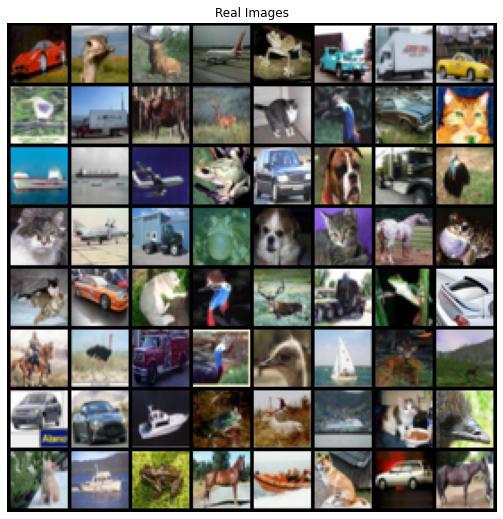

In [10]:
# Add Horizontal Flip by default
tfms = [transforms.RandomHorizontalFlip()]
dataset =  ImageDataset('cifar_10', batch_sz=dis_batch_sz, tfms=tfms, 
                        num_workers=2, drop_last=True)
display_images(dataset.train_loader)

In [11]:
Gen = TGenerator(latent_dims=latent_dims).to(device)
fixed_z = torch.randn(gen_batch_sz, latent_dims, device=device)
# summary(Gen,(latent_dims,))

## Generator Co-task

In [12]:
from models.layers import LinearReshape
bottom_width, embed_chs =  Gen.bottom_width, Gen.embed_chs
ct_in_layer = LinearReshape(in_dims=3, out_dims=embed_chs//4,
                            width=bottom_width*2, embed_chs=embed_chs//4)
TGenerator.ct_in_layer = ct_in_layer.to(device)
# python magic :)
hasattr(Gen, "ct_in_layer")

True

In [13]:
def super_resolution(self, x):
    """ Start from the 2nd stage of the Generator for now. """
    # Push channels to last dimention and project
    x = self.ct_in_layer(x.permute(0,2,3,1)) 
    for i, blocks in enumerate(self.upsample_block):
        if i == 0:   # skip upsample
             x = x + self.pos_embed[i+1]
        else:    x = self.pixel_upsample[i](x) + self.pos_embed[i+1]
        for blk in blocks:
            x  = blk(x)
    x = self.to_rgb(x)
    return x.contiguous()

In [14]:
TGenerator.super_resolution = super_resolution
hasattr(Gen, "super_resolution")

True

In [15]:
def reduce_resolution(image_batch):
    """ Function to reduce the resolution of an image by half. """
    return F.interpolate(image_batch, scale_factor=0.5, mode='bilinear',
                          align_corners=False, recompute_scale_factor=False)

In [16]:
# @torch.no_grad()
# def pass_one_batch():
#     targ_img = next(iter(dataset.valid_loader))[0]
#     lowres_img = reduce_resolution(targ_img.to(device))
#     gen_img = TGen.super_resolution(lowres_img)

#     improved_img_grid = vutils.make_grid(gen_img.cpu(), padding=2, normalize=True)
#     target_img_grid = vutils.make_grid(targ_img.cpu(), padding=2, normalize=True)
#     lowres_img_grid = vutils.make_grid(lowres_img.cpu(), padding=2, normalize=True)
#     return lowres_img_grid, improved_img_grid, target_img_grid

In [17]:
mse_loss = nn.MSELoss(reduction='mean')
lamb = 50.0

## Continue Training Loop

In [18]:
args = SimpleNamespace(**{"d_depth": 7, "df_dim": 384, "img_size": 32, "patch_size": 8})
Dis = Discriminator(args,augments=augments).to(device)
# summary(Dis,(3,32,32,))

In [19]:
optG = optim.AdamW(Gen.parameters(), lr=lr, betas=(beta1, beta2))
optD = optim.AdamW(Dis.parameters(), lr=lr, betas=(beta1, beta2))

In [20]:
loss_logs = {'gen_loss': [], 'dis_loss': []}
img_list = []

In [23]:
ckp_class = Checkpoint(ckp_folder, max_epochs=num_epochs, num_ckps=40, start_after=0.025)

# check if any existing checkpoint exists, none found hence start_epoch is 0.
# Optimizer states also get saved
Gen, Dis, optG, optD, start_epoch, old_logs = \
                        ckp_class.check_if_exists(Gen, Dis, optG, optD)

loss_logs = old_logs or loss_logs
start_epoch #, loss_logs

0

In [24]:
# number of prints per epoch 
num = 4
print_at = np.linspace(100, len(dataset.train_loader)-1, num=num, dtype=np.int).tolist()

In [ ]:
for epoch in tqdm(range(start_epoch, num_epochs)):
    for i, data in enumerate(tqdm(dataset.train_loader, leave=False)):
        
        ###########################
        # (1) Update Dis network
        ###########################
        
        ## Train with all-real batch
        Dis.zero_grad()
        real = data[0].to(device)
        output_real = Dis(real).view(-1)

        ## Train with all-fake batch
        dis_z = torch.randn(dis_batch_sz, latent_dims, device=device)
        fake_1 = Gen(dis_z).detach()
        output_fake_1 = Dis(fake_1).view(-1)

        ## Compute loss and backpropagate
        errD = wgangp_eps_loss(Dis, real, fake_1, 1.0, output_real, output_fake_1)
        errD.backward()
        torch.nn.utils.clip_grad_norm_(Dis.parameters(), 5.0)
        optD.step()

        ###########################
        # (2) Update Gen network
        ###########################
        
        Gen.zero_grad()
        gen_z = torch.randn(gen_batch_sz, latent_dims, device=device)
        fake_2 = Gen(gen_z)
        output_fake_2 = Dis(fake_2).view(-1)
        errG = -torch.mean(output_fake_2)

        # Co-training task
        low_res_img = reduce_resolution(real)
        generated_img = Gen.super_resolution(low_res_img)
        co_train_loss = mse_loss(generated_img, real)

        errG += lamb * co_train_loss
        errG.backward()
        torch.nn.utils.clip_grad_norm_(Gen.parameters(), 5.0)
        optG.step()

        ###########################
        # (3) Output
        ###########################

        # Save Losses for plotting later
        loss_logs['gen_loss'].append(errG.item())
        loss_logs['dis_loss'].append(errD.item())

        if i in print_at:
            # Output training stats averged over last 100 iterations
            gen_mean = np.mean(loss_logs['gen_loss'][-100:])
            dis_mean = np.mean(loss_logs['dis_loss'][-100:])
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataset.train_loader)}]\t'
                  f'Loss_D: {round(gen_mean, 4)}\t',
                  f'Loss_G: {round(dis_mean, 4)}')
        
            # Check how the generator is doing by saving G's output on fixed_noise
            with torch.no_grad():
                fixed_fake = Gen(fixed_z).detach().cpu()
            img_list.append(vutils.make_grid(fixed_fake, padding=2, normalize=True))
    
    # Checkpoint
    ckp_class.at_epoch_end(Gen, Dis, optG, optD, epoch=epoch, loss_logs=loss_logs)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

[0/200][100/1562]	Loss_D: 3.2876	 Loss_G: 1.3553
[0/200][587/1562]	Loss_D: 1.7255	 Loss_G: 0.1604
[0/200][1074/1562]	Loss_D: 1.7567	 Loss_G: -0.0741
[0/200][1561/1562]	Loss_D: 1.8666	 Loss_G: 0.0365


  0%|          | 0/1562 [00:00<?, ?it/s]

[1/200][100/1562]	Loss_D: 1.6914	 Loss_G: -0.0008
[1/200][587/1562]	Loss_D: 1.6377	 Loss_G: 0.0763
[1/200][1074/1562]	Loss_D: 1.3477	 Loss_G: 0.0634
[1/200][1561/1562]	Loss_D: 1.3703	 Loss_G: 0.1101


  0%|          | 0/1562 [00:00<?, ?it/s]

[2/200][100/1562]	Loss_D: 1.5	 Loss_G: 0.1477
[2/200][587/1562]	Loss_D: 1.1927	 Loss_G: 0.1473
[2/200][1074/1562]	Loss_D: 1.1469	 Loss_G: 0.19
[2/200][1561/1562]	Loss_D: 1.2443	 Loss_G: 0.1801


  0%|          | 0/1562 [00:00<?, ?it/s]

[3/200][100/1562]	Loss_D: 1.1008	 Loss_G: 0.204
[3/200][587/1562]	Loss_D: 1.0353	 Loss_G: 0.1883
[3/200][1074/1562]	Loss_D: 1.1629	 Loss_G: 0.1997
[3/200][1561/1562]	Loss_D: 1.1094	 Loss_G: 0.2176


  0%|          | 0/1562 [00:00<?, ?it/s]

[4/200][100/1562]	Loss_D: 1.1013	 Loss_G: 0.1645
[4/200][587/1562]	Loss_D: 1.2446	 Loss_G: 0.2068
[4/200][1074/1562]	Loss_D: 1.0439	 Loss_G: 0.1521
[4/200][1561/1562]	Loss_D: 1.2004	 Loss_G: 0.1838


  0%|          | 0/1562 [00:00<?, ?it/s]

[5/200][100/1562]	Loss_D: 1.1818	 Loss_G: 0.1298
[5/200][587/1562]	Loss_D: 0.9518	 Loss_G: 0.194
[5/200][1074/1562]	Loss_D: 1.1463	 Loss_G: 0.2215
[5/200][1561/1562]	Loss_D: 1.1001	 Loss_G: 0.2118
=> Saving Checkpoint with name `GanModel_005.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[6/200][100/1562]	Loss_D: 1.1561	 Loss_G: 0.2
[6/200][587/1562]	Loss_D: 1.1603	 Loss_G: 0.2216
[6/200][1074/1562]	Loss_D: 1.1162	 Loss_G: 0.2006
[6/200][1561/1562]	Loss_D: 1.0278	 Loss_G: 0.1989


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcaabe97170>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcaabe97170>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():

AssertionError  File "/opt/conda/lib/python3.7/multiprocessing

[7/200][100/1562]	Loss_D: 1.107	 Loss_G: 0.1869
[7/200][587/1562]	Loss_D: 1.0255	 Loss_G: 0.1684
[7/200][1074/1562]	Loss_D: 0.8546	 Loss_G: 0.1866
[7/200][1561/1562]	Loss_D: 1.1734	 Loss_G: 0.2081


  0%|          | 0/1562 [00:00<?, ?it/s]

[8/200][100/1562]	Loss_D: 1.1598	 Loss_G: 0.2006
[8/200][587/1562]	Loss_D: 1.1457	 Loss_G: 0.1735
[8/200][1074/1562]	Loss_D: 1.0689	 Loss_G: 0.166
[8/200][1561/1562]	Loss_D: 0.982	 Loss_G: 0.1688


  0%|          | 0/1562 [00:00<?, ?it/s]

[9/200][100/1562]	Loss_D: 1.0877	 Loss_G: 0.1747
[9/200][587/1562]	Loss_D: 1.2056	 Loss_G: 0.1683
[9/200][1074/1562]	Loss_D: 1.2276	 Loss_G: 0.1682
[9/200][1561/1562]	Loss_D: 1.0593	 Loss_G: 0.1819


  0%|          | 0/1562 [00:00<?, ?it/s]

[10/200][100/1562]	Loss_D: 1.0284	 Loss_G: 0.1661
[10/200][587/1562]	Loss_D: 1.163	 Loss_G: 0.1698
[10/200][1074/1562]	Loss_D: 0.9298	 Loss_G: 0.1396
[10/200][1561/1562]	Loss_D: 1.0389	 Loss_G: 0.1557
=> Saving Checkpoint with name `GanModel_010.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[11/200][100/1562]	Loss_D: 1.0019	 Loss_G: 0.1716
[11/200][587/1562]	Loss_D: 1.052	 Loss_G: 0.1345
[11/200][1074/1562]	Loss_D: 0.9522	 Loss_G: 0.1693
[11/200][1561/1562]	Loss_D: 1.1522	 Loss_G: 0.1783


  0%|          | 0/1562 [00:00<?, ?it/s]

[12/200][100/1562]	Loss_D: 1.0576	 Loss_G: 0.1588
[12/200][587/1562]	Loss_D: 1.0378	 Loss_G: 0.1376
[12/200][1074/1562]	Loss_D: 1.221	 Loss_G: 0.17
[12/200][1561/1562]	Loss_D: 1.0615	 Loss_G: 0.1554


  0%|          | 0/1562 [00:00<?, ?it/s]

[13/200][100/1562]	Loss_D: 1.0169	 Loss_G: 0.1703
[13/200][587/1562]	Loss_D: 0.9325	 Loss_G: 0.1814
[13/200][1074/1562]	Loss_D: 1.0529	 Loss_G: 0.163
[13/200][1561/1562]	Loss_D: 0.9736	 Loss_G: 0.1494


  0%|          | 0/1562 [00:00<?, ?it/s]

[14/200][100/1562]	Loss_D: 1.0202	 Loss_G: 0.1365
[14/200][587/1562]	Loss_D: 1.0367	 Loss_G: 0.1322
[14/200][1074/1562]	Loss_D: 0.9273	 Loss_G: 0.1923
[14/200][1561/1562]	Loss_D: 0.979	 Loss_G: 0.1554


  0%|          | 0/1562 [00:00<?, ?it/s]

[15/200][100/1562]	Loss_D: 1.0369	 Loss_G: 0.1478
[15/200][587/1562]	Loss_D: 1.0569	 Loss_G: 0.1548
[15/200][1074/1562]	Loss_D: 1.0217	 Loss_G: 0.1721
[15/200][1561/1562]	Loss_D: 0.8872	 Loss_G: 0.2033
=> Saving Checkpoint with name `GanModel_015.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[16/200][100/1562]	Loss_D: 0.9628	 Loss_G: 0.1579
[16/200][587/1562]	Loss_D: 0.9966	 Loss_G: 0.1707
[16/200][1074/1562]	Loss_D: 1.0631	 Loss_G: 0.1748
[16/200][1561/1562]	Loss_D: 1.0026	 Loss_G: 0.179


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcaabe97170>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcaabe97170>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

[17/200][100/1562]	Loss_D: 0.8994	 Loss_G: 0.1611
[17/200][587/1562]	Loss_D: 0.8462	 Loss_G: 0.1402
[17/200][1074/1562]	Loss_D: 0.924	 Loss_G: 0.1766
[17/200][1561/1562]	Loss_D: 0.9217	 Loss_G: 0.1734


  0%|          | 0/1562 [00:00<?, ?it/s]

[18/200][100/1562]	Loss_D: 0.8919	 Loss_G: 0.203
[18/200][587/1562]	Loss_D: 0.8513	 Loss_G: 0.163
[18/200][1074/1562]	Loss_D: 0.8215	 Loss_G: 0.1689
[18/200][1561/1562]	Loss_D: 0.8364	 Loss_G: 0.1696


  0%|          | 0/1562 [00:00<?, ?it/s]

[19/200][100/1562]	Loss_D: 0.8689	 Loss_G: 0.1662
[19/200][587/1562]	Loss_D: 0.8555	 Loss_G: 0.1764
[19/200][1074/1562]	Loss_D: 0.8659	 Loss_G: 0.1707
[19/200][1561/1562]	Loss_D: 0.7505	 Loss_G: 0.1689


  0%|          | 0/1562 [00:00<?, ?it/s]

[20/200][100/1562]	Loss_D: 0.7292	 Loss_G: 0.1769
[20/200][587/1562]	Loss_D: 0.7155	 Loss_G: 0.1745
[20/200][1074/1562]	Loss_D: 0.8276	 Loss_G: 0.1828
[20/200][1561/1562]	Loss_D: 0.779	 Loss_G: 0.1773
=> Saving Checkpoint with name `GanModel_020.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[21/200][100/1562]	Loss_D: 0.7996	 Loss_G: 0.192
[21/200][587/1562]	Loss_D: 0.7674	 Loss_G: 0.1717
[21/200][1074/1562]	Loss_D: 0.6554	 Loss_G: 0.1952
[21/200][1561/1562]	Loss_D: 0.6954	 Loss_G: 0.1928


  0%|          | 0/1562 [00:00<?, ?it/s]

[22/200][100/1562]	Loss_D: 0.7353	 Loss_G: 0.1639
[22/200][587/1562]	Loss_D: 0.6654	 Loss_G: 0.1825
[22/200][1074/1562]	Loss_D: 0.6208	 Loss_G: 0.1587
[22/200][1561/1562]	Loss_D: 0.6928	 Loss_G: 0.1865


  0%|          | 0/1562 [00:00<?, ?it/s]

[23/200][100/1562]	Loss_D: 0.7777	 Loss_G: 0.1564
[23/200][587/1562]	Loss_D: 0.6605	 Loss_G: 0.1717
[23/200][1074/1562]	Loss_D: 0.6357	 Loss_G: 0.1668
[23/200][1561/1562]	Loss_D: 0.6906	 Loss_G: 0.1849


  0%|          | 0/1562 [00:00<?, ?it/s]

[24/200][100/1562]	Loss_D: 0.7238	 Loss_G: 0.2129
[24/200][587/1562]	Loss_D: 0.7567	 Loss_G: 0.1819
[24/200][1074/1562]	Loss_D: 0.6719	 Loss_G: 0.2029
[24/200][1561/1562]	Loss_D: 0.5779	 Loss_G: 0.1804


  0%|          | 0/1562 [00:00<?, ?it/s]

[25/200][100/1562]	Loss_D: 0.6753	 Loss_G: 0.1451
[25/200][587/1562]	Loss_D: 0.7445	 Loss_G: 0.1781
[25/200][1074/1562]	Loss_D: 0.6478	 Loss_G: 0.193
[25/200][1561/1562]	Loss_D: 0.6041	 Loss_G: 0.1884
=> Saving Checkpoint with name `GanModel_025.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[26/200][100/1562]	Loss_D: 0.6186	 Loss_G: 0.1806
[26/200][587/1562]	Loss_D: 0.548	 Loss_G: 0.1862
[26/200][1074/1562]	Loss_D: 0.6235	 Loss_G: 0.2222
[26/200][1561/1562]	Loss_D: 0.5853	 Loss_G: 0.1948


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcaabe97170>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fcaabe97170>

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorself._shutdown_workers(): 
can only test a child process  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers

    if w.is_alive():
  File "/opt/con

[27/200][100/1562]	Loss_D: 0.6427	 Loss_G: 0.177
[27/200][587/1562]	Loss_D: 0.5441	 Loss_G: 0.2248
[27/200][1074/1562]	Loss_D: 0.6018	 Loss_G: 0.2082
[27/200][1561/1562]	Loss_D: 0.6589	 Loss_G: 0.2091


  0%|          | 0/1562 [00:00<?, ?it/s]

[28/200][100/1562]	Loss_D: 0.7445	 Loss_G: 0.1959
[28/200][587/1562]	Loss_D: 0.6105	 Loss_G: 0.2078
[28/200][1074/1562]	Loss_D: 0.6361	 Loss_G: 0.2227
[28/200][1561/1562]	Loss_D: 0.6028	 Loss_G: 0.2234


  0%|          | 0/1562 [00:00<?, ?it/s]

[29/200][100/1562]	Loss_D: 0.4537	 Loss_G: 0.1864
[29/200][587/1562]	Loss_D: 0.563	 Loss_G: 0.1719
[29/200][1074/1562]	Loss_D: 0.6518	 Loss_G: 0.1672
[29/200][1561/1562]	Loss_D: 0.5749	 Loss_G: 0.2085


  0%|          | 0/1562 [00:00<?, ?it/s]

[30/200][100/1562]	Loss_D: 0.5842	 Loss_G: 0.2269
[30/200][587/1562]	Loss_D: 0.5286	 Loss_G: 0.1998
[30/200][1074/1562]	Loss_D: 0.7163	 Loss_G: 0.1796
[30/200][1561/1562]	Loss_D: 0.6193	 Loss_G: 0.2091
=> Saving Checkpoint with name `GanModel_030.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[31/200][100/1562]	Loss_D: 0.5497	 Loss_G: 0.2048
[31/200][587/1562]	Loss_D: 0.6793	 Loss_G: 0.2111
[31/200][1074/1562]	Loss_D: 0.5337	 Loss_G: 0.131
[31/200][1561/1562]	Loss_D: 0.4479	 Loss_G: 0.1972


  0%|          | 0/1562 [00:00<?, ?it/s]

[32/200][100/1562]	Loss_D: 0.5267	 Loss_G: 0.2277
[32/200][587/1562]	Loss_D: 0.613	 Loss_G: 0.2011
[32/200][1074/1562]	Loss_D: 0.4789	 Loss_G: 0.2082
[32/200][1561/1562]	Loss_D: 0.6763	 Loss_G: 0.1964


  0%|          | 0/1562 [00:00<?, ?it/s]

[33/200][100/1562]	Loss_D: 0.5608	 Loss_G: 0.2204
[33/200][587/1562]	Loss_D: 0.5605	 Loss_G: 0.2017
[33/200][1074/1562]	Loss_D: 0.6401	 Loss_G: 0.1768
[33/200][1561/1562]	Loss_D: 0.5232	 Loss_G: 0.1731


  0%|          | 0/1562 [00:00<?, ?it/s]

[34/200][100/1562]	Loss_D: 0.6401	 Loss_G: 0.2107
[34/200][587/1562]	Loss_D: 0.3844	 Loss_G: 0.8496
[34/200][1074/1562]	Loss_D: 0.525	 Loss_G: 0.1814
[34/200][1561/1562]	Loss_D: 0.6059	 Loss_G: 0.2035


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcaabe97170>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fcaabe97170>  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__

Traceback (most recent call last):
    self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__

    self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        assert self._parent_pid == os.getpid(), 'can o

# Analysis

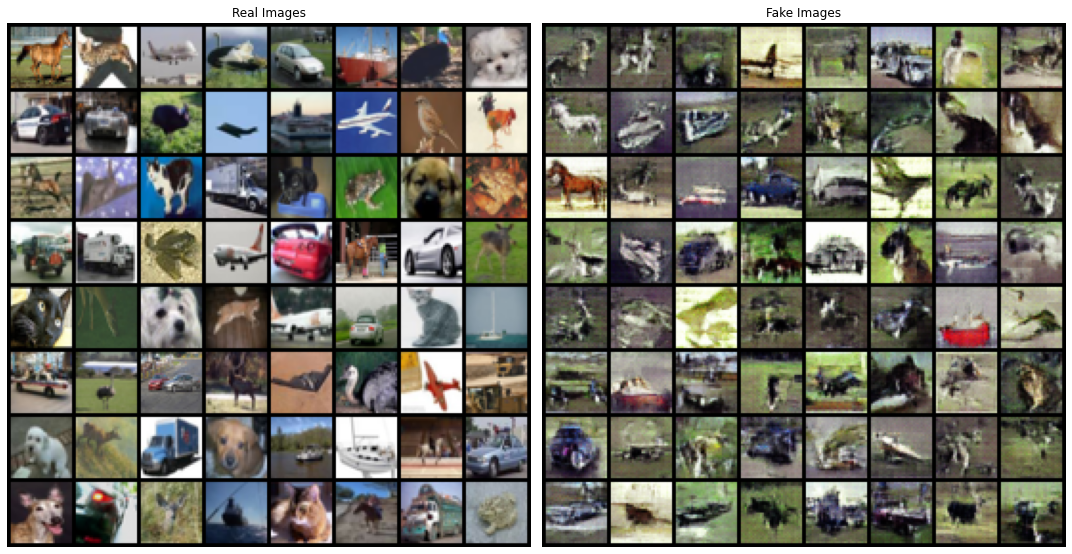

In [24]:
_, axs = plt.subplots(1,2,figsize=(15,15))
display_images(dataset.train_loader,ax = axs[0])
display_images(img_list, ax = axs[1])
plt.tight_layout()

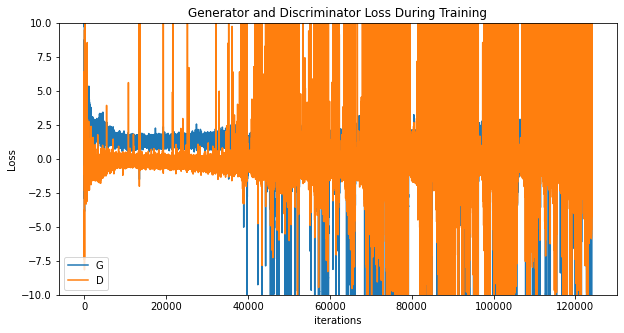

In [25]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_logs['gen_loss'],label="G")
plt.plot(loss_logs['dis_loss'],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.ylim([-10,10])
plt.legend()
plt.show()

Calculating FID Score

In [27]:
from metrics.torch_is_fid_score import is_fid_from_generator
stat_path = Path('fid_stats/cifar_10_valid_fid_stats.npz')
inception_score, fid = is_fid_from_generator(generator=Gen,
                                        latent_dims=latent_dims,
                                        num_imgs=10000,
                                        batch_sz=256,
                                        fid_stat_path = stat_path)

generating images:   0%|          | 0/40 [00:00<?, ?it/s]

inception_score_and_fid:   0%|          | 0/10000 [00:00<?, ?it/s]

In [28]:
print(f"\nFID score: {fid}")
print(f"\nIS: {inception_score}")


FID score: 81.04901123046875

IS: (5.476717472076416, 0.12598292529582977)


In [ ]:
# rc('animation', html='jshtml')
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# ani

In [ ]:
!kill $(ps aux | awk '{print $2}')